# Spike count data regression

### Table of contents

1. [**Data**](#data)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)


In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")


import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()  # PyTorch device, gpu 0 by default if available

PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [ ]:
# plotting functions
def raster_plot(
    figax, spikes, time_bins, bin_time, units, colors=None, marker="|", markersize=2
):
    """
    Visualize a 2D array representing point events, spikes has shape (timstep, units).

    :param list colors: colors to be included in the colormap
    :param string name: name the colormap
    :returns: figure and axis
    :rtype: tuple
    """
    fig, ax = figax
    if colors is None:
        col = ["k"] * units
    else:
        col = colors
    for i in range(units):
        t = np.nonzero(spikes[i, :])[0] * bin_time
        ax.scatter(t, (i + 1) * np.ones_like(t), c=col[i], s=markersize, marker=marker)

    ax.set_xlim(0, time_bins * bin_time)
    ax.set_ylim(0.1, units + 0.9)
    ax.set_yticks(np.arange(1, units + 1))
    
    
    
def posterior_rate(mapping, likelihood, covariates, MC, F_dims, trials=1, percentiles=[0.05, .5, 0.95]):
    """
    Sample F from diagonalized variational posterior.
    
    :returns: F of shape (MCxtrials, outdims, time)
    """
    cov = mapping.to_XZ(covariates, trials)
    with torch.no_grad():
        if mapping.MC_only:
            F = mapping.sample_F(cov)[:, F_dims, :] # TODO: cov_samples vs ll_samples?
            samples = likelihood.f(F.view(-1, trials, *samples.shape[1:]))
        else:
            F_mu, F_var = mapping.compute_F(cov)
            samples = likelihood.sample_rate(
                F_mu[:, F_dims, :], F_var[:, F_dims, :], trials, MC)
    
    return utils.signal.percentiles_from_samples(samples, percentiles)



# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

<a id="synthetic"></a>
## 1. Synthetic heteroscedastic count data

In [5]:
def HDC_bumps(theta, A, invbeta, b, theta_0):
    """
    parameters have shape (neurons,)
    :return:
        rates of shape (..., neurons, eval_pts)
    """
    return A[:, None] * np.exp(
        (np.cos(theta[..., None, :] - theta_0[:, None]) - 1) / invbeta[:, None]) + b[:, None]


In [6]:
rng = np.random.default_rng(123)

# Gaussian von Mises bump head direction model
track_samples = 4000
hd_t = np.empty(track_samples)
hd_t[0] = 0#np.pi
rn = rng.normal(size=(track_samples,))
for k in range(1, track_samples):
    hd_t[k] = hd_t[k-1] + 0.1*rn[k]
    
hd_t = hd_t % (2*np.pi)

In [18]:
sample_bin = 0.05
neurons = 50

# Von Mises fields
angle_0 = np.linspace(0, 2*np.pi, neurons+1)[:-1]
beta = 0.3 + rng.uniform(size=(neurons,)) * 0.1
rate_0 = rng.uniform(size=(neurons,)) * 5.0 + 1.0
b = rng.uniform(size=(neurons,)) * 1.

# Dispersion tuning curve
_angle_0 = rng.permutation(angle_0)
_beta = (0.2 * rng.normal(size=(neurons,)))**2 + 0.01
_rate_0 = rng.uniform(size=(neurons,)) * 500.0 + 500.0
_b = rng.uniform(size=(neurons,)) * 1.

# functions
vm_rate = lambda x: HDC_bumps(x, rate_0, 1./beta, b, angle_0)
vm_disp = lambda x: HDC_bumps(x, _rate_0, 1./_beta, _b, _angle_0)

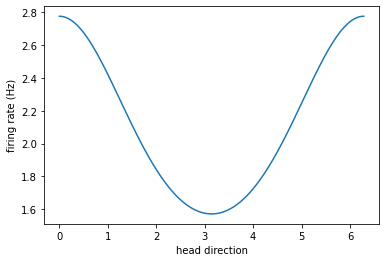

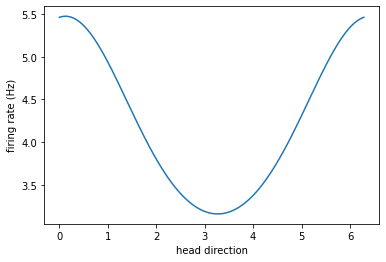

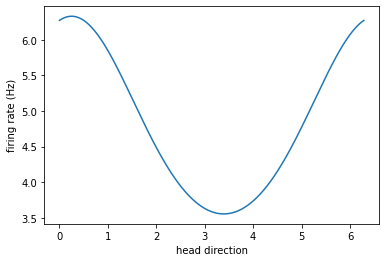

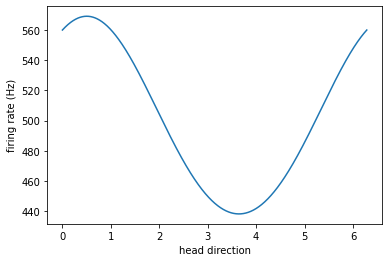

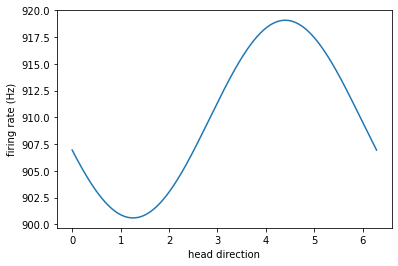

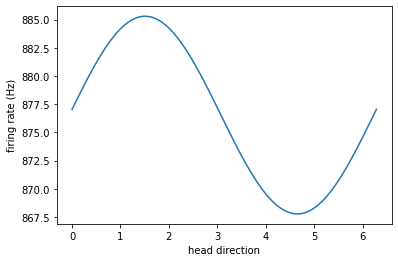

In [20]:
steps= 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)

mean = vm_rate(covariates)
for k, ne in enumerate(show_neurons):
    
    fig, ax = plt.subplots()
    line, = ax.plot(covariates, mean[ne, :])
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')
    
plt.show()


mean = vm_disp(covariates)
for k, ne in enumerate(show_neurons):
    
    fig, ax = plt.subplots()
    line, = ax.plot(covariates, mean[ne, :])
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')
    
plt.show()

In [5]:
# Count process output
alpha = 0.2*np.ones(neurons)
likelihood = nprb.likelihoods.COM_Poisson(sample_bin, neurons, 'exp', alpha)

trials = 1
ll_samples = 10
in_dims = 1

XZ = torch.tensor(hd_t[None, :, None]).float() # MC, T, D
F_mu, F_var = vm_rate.compute_F(XZ) 
rate = likelihood.sample_rate(F_mu, F_var, trials, ll_samples) # MC, trials, neuron, time

rate = rate.mean(0).numpy()
#h = nprb.inference.sample_F(vm_rate, likelihood, [hd_t], 10, list(range(neurons)))
syn_train = likelihood.sample(rate, XZ=XZ)

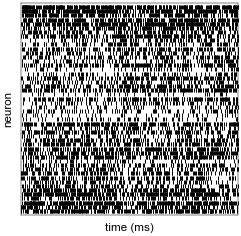

In [6]:
tr = 0
T = 1000

fig, ax = plt.subplots(figsize=(4,4))
utils.plot.raster_plot((fig, ax), syn_train[tr, :, :T], T, sample_bin*1000, neurons, markersize=10)
utils.plot.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

<a id="recovery"></a>
## 2. Synthetic data model recovery

In [12]:
l = 10.*np.array([np.ones(1)])
v = np.ones(1)
kernels_tuples = [('variance', v), ('RBF', 'torus', l)]
VI_tuples = [(None, None, None, 1)]
ini_X = [hd_t]

In [17]:
cp = False

num_induc = 8
inducing_points = np.linspace(0, 2*np.pi, num_induc+1)[None, :-1, None].repeat(neurons, axis=0)

gpr = nprb.nonparametrics.Gaussian_process(
    in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
    inv_link='exp', whiten=True, jitter=1e-6, mean=np.zeros(neurons), learn_mean=True
)

gpd = nprb.nonparametrics.Gaussian_process(
    in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
    inv_link='exp', whiten=True, jitter=1e-6, mean=np.zeros(neurons), learn_mean=True
)


In [18]:
### inputs and likelihood ###
inputs = nprb.inference.input_group(in_dims, VI_tuples)
inputs.set_XZ(ini_X, track_samples, batch_size=1000, filter_len=1)  

likelihood = nprb.likelihoods.Poisson(sample_bin, neurons, 'exp')
#r_inv = 10.*np.ones(neurons)
#likelihood = nprb.likelihoods.Negative_binomial(sample_bin, neurons, 'exp', r_inv)
#alpha = .1*np.ones(neurons)
#likelihood = nprb.likelihoods.ZI_Poisson(sample_bin, neurons, 'exp', alpha, dispersion_mapping=None)
likelihood.set_Y(syn_train, batch_size=1000, filter_len=1) 


glm = nprb.inference.VI_optimized(inputs, gpr, likelihood)
glm.to(dev)

VI_optimized(
  (inputs): input_group()
  (mapping): Gaussian_process(
    (kernel): Product(
      (kern0): Constant()
      (kern1): RBF()
    )
  )
  (likelihood): Poisson()
)

In [19]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-3}

glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, bound='ELBO', ll_mode='MC')

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

KeyboardInterrupt: 

### Inspect posterior

In [15]:
#print(glm.likelihood.alpha)

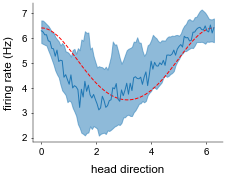

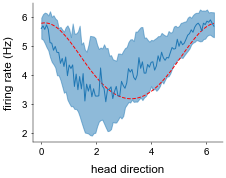

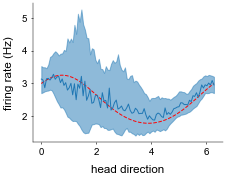

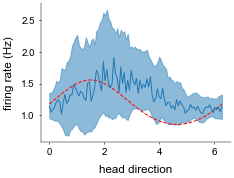

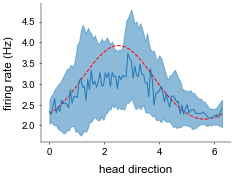

In [20]:
steps= 100
show_neurons = [0, 1, 6, 12, 20]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

r_true = vm_rate.eval_rate(covariates, show_neurons)

lower, mean, upper = gpr.eval_rate(covariates, show_neurons, 'posterior', n_samp=10)
for k, neuron in enumerate(show_neurons):

    fig, ax = plt.subplots()
    ax.plot(covariates[0], r_true[0, k], 'r--')
    line, = ax.plot(covariates[0], mean[0, k])
    ax.fill_between(
        covariates[0], lower[0, k],
        upper[0, k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')

plt.show()

### Compute statistics

In [93]:
def get_field(glm_rate, grid_size, grid_shape, neuron):

    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = [x, y]
        return glm_rate.eval_rate(covariates, neuron).reshape(-1, *prevshape)

    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    return field


def compute_rate(glm_rate, neuron):
    grid_size = [50, 40]
    grid_shape = [[left_x, right_x], [bottom_y, top_y]]
    field = get_field(glm_rate, grid_size, grid_shape, neuron)
    return field

def compute_stats(glm, spktrain, behav_list): # statistics
    glm_rate = glm.rate_model[0]
    glm_lik = glm.likelihood
    
    bs = 5000
    T = 100000
    traj_len = 1
    N = int(np.ceil(T/bs))
    rate_model = []
    spktrain = spktrain[:T]

    for n in range(N):
        covariates_ = [b[n*bs:(n+1)*bs] for b in behav_list]
        rate_model += [glm_rate.eval_rate(covariates_, [0])[0]]

    rate_model = np.concatenate(rate_model)

    f_p = lambda c, avg, shape, t: stats.nb_count_prob(c, avg, shape, t)
    m_f = lambda x: x
    cnt_tuple = stats.count_KS_method(f_p, m_f, glm_rate.tbin.item(), spktrain, rate_model, \
                                      traj_len, shape=glm_lik.r_inv[0].item(), min_spikes=0)
    q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS, traj_lens = cnt_tuple

    return q_cdf, Z_DS, T_KS, s_KS

In [94]:
q_cdf, Z_DS, T_KS, s_KS = compute_stats(glm, rc_t[0], [rhd_t])

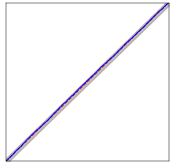

0.0095291454015618
-0.14628394160774894


In [95]:
fig = plt.figure(figsize=(3, 3))
ax = fig.subplots()
ax = stats.plot_dispersion(ax, q_cdf, s_KS)
plt.show()
print(T_KS)
print(Z_DS)

<a id="ucm"></a>
## 3. Fitting the UCM


<a id='assess'></a>
## 4. Assessing goodness-of-fit

We can evaluate the held-out test log likelihood with the above. Repeating over all folds will give us $k$-fold cross-validation, in this case we have $k=5$. Below we compute the test log likelihood for one fold.

In [92]:
# LL
train = validation_set[1]
ts = train+1.

ll = lib.helper.RG_pred_ll(
    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
    ll_samples=1, cov_samples=1, beta=0.0
)
print(ll)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

Apart from the likelihood score, a more direct measure of goodness-of-fit is given by the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) adapted to count distributions. We compute the predictive spike count distribution given input covariates and then compute the quantiles of the observed spike counts. These are obtained from the training data, and will thus show us how well the model was able to fit in an absolute sense. We can turn these into $Z$-scores (which will be unit normal distributed if the model describes observations well).

In [5]:
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, data_name = dataset_tuple

# quantiles, Z scores
P_ = []
for b in range(modelfit.input_group.batches):
    covariates, _ = modelfit.input_group.sample_XZ(b, samples=1)  # get the training batch b
    with torch.no_grad():
        P_mc = lib.helper.compute_P(modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
    P_.append(P_mc.mean(0).cpu().numpy())  # take mean over MC samples
P = np.concatenate(P_, axis=1)  # count probabilities of shape (neurons, timesteps, count)


q = []
Z = []
trial = 0
for n in range(units_used):
    batch_edge, _, _ = modelfit.likelihood.batch_info
    spike_binned = modelfit.likelihood.all_spikes[trial, n, :].numpy()
    q_, Z_ = lib.helper.get_q_Z(P[n, ...], spike_binned, deq_noise=None)
    q.append(q_)
    Z.append(Z_)

q = np.array(q)  # quantiles of shape (neurons, timesteps)
Z = np.array(Z)  # Z scores of shape (neurons, timesteps)

We can obtain the Kolmogorov-Smirnov test statistic $T_{KS}$, and the dispersion statistic $T_{DS}$ as well (see paper). These statistics are computed per neuron and reflect single neuron goodness-of-fit measures. The $T_{KS}$ statistic seems to be roughly distributed as the sampling distribution under the null model, i.e. if the model generated the data this would be the distribution of $T_{KS}$ observed for an infinite number of repetitions of random data draws.

In [6]:
T_DS_bn = []
T_KS_bn = []
for qq in q:
    T_DS, T_KS, sign_DS, sign_KS, p_DS, p_KS = utils.stats.KS_statistics(qq, alpha=0.05, alpha_s=0.05)
    T_DS_bn.append(T_DS)
    T_KS_bn.append(T_KS)

T_DS_bn = np.array(T_DS_bn)  # (neurons,)
T_KS_bn = np.array(T_KS_bn)

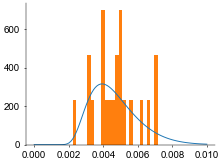

In [7]:
x = np.linspace(0, 0.01, 100)
f = utils.stats.KS_sampling_dist(x, len(q[0]))
plt.plot(x, f)
plt.hist(T_KS_bn, bins=np.linspace(0, 0.01, 50), density=True)
plt.show()

If single neuron statistics are captured well, we could still have correlations between the $Z$-scores that indicate neural correlations not explained by the input covariates. For instance, a neuron pair could happen to fire more or less spikes than their average during similar periods, which will show up as positive correlations between the $Z$-scores. If the model captures all correlations, i.e. it accounts for all co-fluctuations between neuron pairs, then we should see only insignificant correlations.

In [8]:
# neural correlations
R = np.zeros((units_used, units_used))
R_p = []
for n in range(units_used):
    for k in range(n+1, units_used):
        r, r_p = sc.stats.pearsonr(Z[n], Z[k]) # Pearson r correlation test
        R[n, k] = r
        R_p.append(r_p)
        
R = R + R.T  # symmetrize
R_p = np.array(R_p)

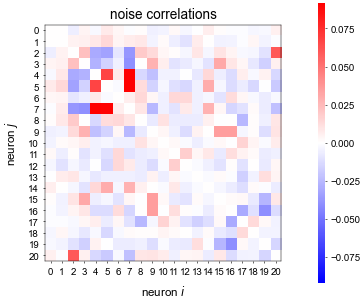

In [9]:
Rmax = max(-R.min(), R.max())

fig = plt.figure(figsize=(4, 4))
widths = [1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 0])
utils.plot.decorate_ax(ax)  # get all four spines around plot
im = ax.imshow(R, cmap=weight_map, vmin=-Rmax, vmax=Rmax)
ax.set_xlabel('neuron $i$')
ax.set_ylabel('neuron $j$')
ax.set_title('noise correlations')
ax.set_xticks(np.arange(units_used))
ax.set_yticks(np.arange(units_used))

ax = fig.add_subplot(spec[0, 1])
utils.plot.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)

plt.show()

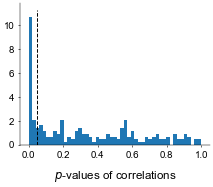

In [10]:
fig, ax = plt.subplots()
ax.hist(R_p, bins=np.linspace(0, 1, 50), density=True)
ylims = ax.get_ylim()
ax.plot(2*[0.05], ylims, 'k--')
ax.set_xlabel(r'$p$-values of correlations')
plt.show()

<a id='SCD'></a>
## 5. Computing spike count distributions

Now we load a model that has been trained on the entire dataset, which we specify by setting ```cv_run = -1```.

In [29]:
bin_size = 50  # ms
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 5000  # size of time segments of each batch in dataset below

    
# data
dataset_tuple = HDC.get_dataset(session_id, phase, bin_size, single_spikes, path='./')

# model and train/test split based on which validation fold is given by cv_run
modelfit, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_info, dataset_tuple, HDC.inputs_used, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5
)

We can compute the spike count distribution conditioned on input covariates, and in this way we can explore the neural tuning over a slice through input space. We set all other covariates at the mean values of the observed time series in the dataset.

In [30]:
hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

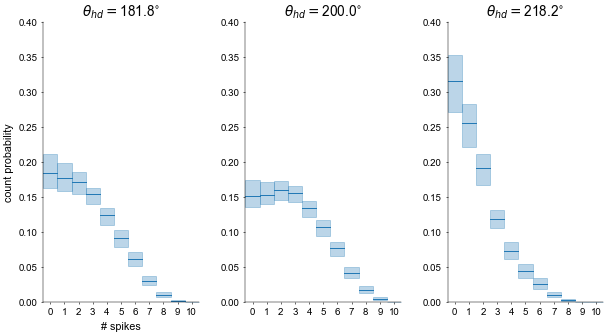

In [31]:
# histograms
lower, mean, upper = utils.signal.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ne = 20  # select neuron
K = P_mc.shape[-1]
for en, step_ind in enumerate([50, 55, 60]):
    ax = fig.add_subplot(spec[0, en])
    hd = hd_sweep[step_ind]
    ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(hd / np.pi * 180) + r'$^{\circ}$')
    
    for k in range(K):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2)*mean.numpy()[ne, step_ind, k]
        YY_l = np.ones(2)*lower.numpy()[ne, step_ind, k]
        YY_u = np.ones(2)*upper.numpy()[ne, step_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3)


    ax.set_xlim([-0.5, K-1+.5])
    ax.set_ylim(0, 0.4)
    ax.set_xticks(np.arange(K))
    
    if en == 0:
        ax.set_ylabel('count probability', fontsize=11, labelpad=5)
        ax.set_xlabel('# spikes', labelpad=5, fontsize=11)

plt.show()

Conventional tuning curves show mean firing rate as a function of some covariate. We can plot those by computing the mean of the count distribution.

In [32]:
K = P.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

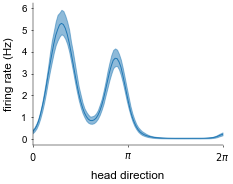

In [54]:
fig, ax = plt.subplots()

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 18  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate (Hz)')
ax.set_xlabel('head direction')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

(100,)
(100,)


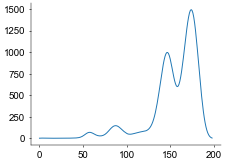

In [55]:
# compute cross correlations

# neurons to compare
ne1 = 15
ne2 = 18
print(mean[ne1, :].numpy().shape)
print(mean[ne2, :].numpy().shape)

correlations = np.correlate(mean[ne1, :].numpy(), mean[ne2, :].numpy(), mode='full')

fig, ax = plt.subplots()
ax.plot(correlations)

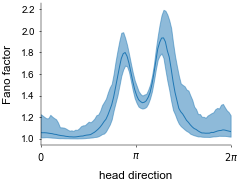

In [16]:
fig, ax = plt.subplots()

lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])
ne = 20  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('Fano factor')
ax.set_xlabel('head direction')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

### 3.1. Firing rate with respect to two covariates

In [17]:
# 2D search, so there will be steps**2 = 10000 covariate vector inputs

steps = 100
hd_sweep = torch.linspace(0, 2*np.pi, steps)
v_sweep = torch.linspace(np.min(rcov[2]), np.max(rcov[2]), steps)

covariates = torch.cat([
    hd_sweep[:, None].expand(-1, steps).reshape(steps**2, 1),
    rcov[1].mean()*torch.ones((steps**2, 1)),
    v_sweep[None, :].expand(steps, -1).flatten().reshape(steps**2, 1),
    *[rcov[k].mean()*torch.ones((steps**2, 1)) for k in range(3, len(rcov))],
], dim=-1)[None, None, ...] # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

In [18]:
K = P.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

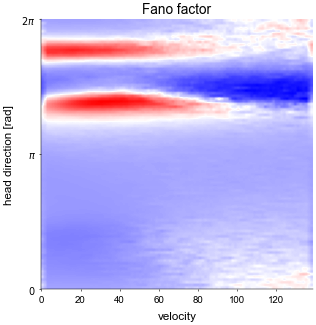

In [19]:
fig, ax = plt.subplots(figsize=(5,5))

lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])
ne = 16  # select neuron to plot

# mean has shape (neurons, steps**2), need to unpack it again
mean = mean.reshape((-1, steps, steps))

ax.imshow(mean[ne, :], cmap=weight_map, extent=[np.min(rcov[2]), np.max(rcov[2]), 0, 2*np.pi], aspect='auto')
ax.set_xlabel('velocity')
ax.set_ylabel('head direction [rad]')
ax.set_title('Fano factor')

ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

plt.show()

Generally, if we want to only look at tuning to one behavioural covariate, we should marginalize out the modulation from all other covariates. This cannot be done in closed form, hence we need to use Monte Carlo sampling where we treat the observed behaviour as a chain of samples and average out over those values conditioned on the relevant behavioural covariate fixed at our evaluation value. This is an expensive operation and implemented in ```scripts/lib/count_stats.py```.


<a id='ucm_inspect'></a>
### 6. Inspecting model parameters

We can load all the kernel hyperparameters, which govern how quickly the neural tuning fluctuates with changes in covariates. The kernel module is a nested module (a product kernel with separable kernels over each covariate dimension). For the circular lengthscale, values way above $2\pi$ indicate little variation in the GP function with head direction, i.e. it is a redundant degree of freedom w.r.t. the head direction (approximately a constant function).

In [20]:
print(modelfit.mapping.kernel.kern0.kern1.track_dims)  # this is a circular kernel over the head direction (covariate dimension 0)
print(modelfit.mapping.kernel.kern1.track_dims)  # this is a Euclidean kernel over other behavioural covariates (dimensions 1 to 5)

[0]
[1, 2, 3, 4, 5]


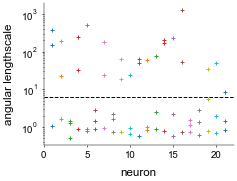

In [21]:
lengthscales = modelfit.mapping.kernel.kern0.kern1.lengthscale.reshape(units_used, -1).data.cpu().numpy()
C = lengthscales.shape[-1]

fig, ax = plt.subplots()

for n in range(units_used):
    ax.scatter((n + 1)*np.ones(C), lengthscales[n, :], marker='+', s=10)
    
ax.plot([0, units_used+1], [2*np.pi, 2*np.pi], 'k--')
ax.set_xlim([0, units_used+1])
ax.set_yscale('log')

ax.set_ylabel('angular lengthscale')
ax.set_xlabel('neuron')
    
plt.show()

The above only holds for one covariate dimension that we looked at. To look at the intrinsic degree of freedom for a neuron, it may be more informative and convenient to look at the softmax weights and biases that connect the GP functions to the spike count distribution. We now load the pre-softmax weights and biases. Each neuron has its own set of weights and biases $W_n$ and $\mathbf{b}_n$. Note we used a exponential-quadratic expansion for $\phi(\cdot)$. This expansion combines the quadratic basis expansion with an exponential mapping, i.e. for a vector $\mathbf{f} = (f_1, f_2)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_1^2, f_2^2, e^{f_1}, e^{f_2}, f_1 f_2)
$$

and for a vector $\mathbf{f} = (f_1, f_2, f_3)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_3, f_1^2, f_2^2, f_3^2, e^{f_1}, e^{f_2}, e^{f_3}, f_1 f_2, f_2 f_3, f_1 f_3)
$$

and so on. The last example here corresponds to the case of $C = 3$ as in the model that we loaded. The probability of spike count $k$ for neuron $n$ is then computed as 

$$
P_{nk} = \text{softmax}\left( W_n \cdot \phi(\mathbf{f}_n) + \mathbf{b}_n \right)_k
$$

Different basis expansions $\phi(\cdot)$ are defined in ```scripts/lib/models.py```.

In [22]:
print(modelfit.likelihood.mapping_net.mnet.net[0].weight.shape)  # (neuron, count, phi(f) dimension)
print(modelfit.likelihood.mapping_net.mnet.net[0].bias.shape)  # (neuron, count)

torch.Size([21, 11, 12])
torch.Size([21, 11])


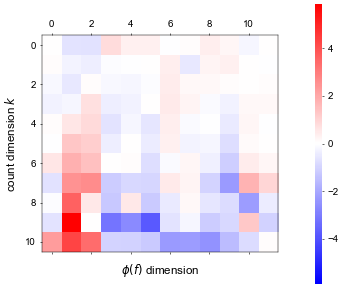

In [23]:
ne = 20  # select neuron
Wn = modelfit.likelihood.mapping_net.mnet.net[0].weight[ne, :, :].data.cpu().numpy()

Wmax = max(-Wn.min(), Wn.max())


fig = plt.figure(figsize=(4, 4))
widths = [1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 0])
utils.plot.decorate_ax(ax)  # get all four spines around plot
im = ax.matshow(Wn, vmin=-Wmax, vmax=Wmax, cmap=weight_map)
ax.set_xlabel(r'$\phi(f)$ dimension')
ax.set_ylabel(r'count dimension $k$')

ax = fig.add_subplot(spec[0, 1])
utils.plot.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)
    
plt.show()

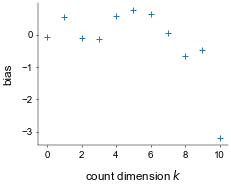

In [24]:
ne = 20  # select neuron
bn = modelfit.likelihood.mapping_net.mnet.net[0].bias[ne, :].data.cpu().numpy()

fig, ax = plt.subplots()
ax.scatter(np.arange(bn.shape[0]), bn, marker='+', s=30)
ax.set_ylabel('bias')
ax.set_xlabel(r'count dimension $k$')
plt.show()